# Attention Weights

**Goal:** Michael said we if made DIPS with attention our model, then we'd need to include that attnetion weights as well, so I'm going to explore getting this code up and running here!!


## Table of Contents

1. [Jet Displays](#jetDisplays)
2. [Attention weights with respect to track composition](#trkLabels)
3. [Attention weights and track features covariance](#trkLabels)
4. [2D track feature plots with attention weights](#2dFeatures)

In [1]:
import numpy as np
import h5py
import sys
import os
import pandas as pd
import xarray as xr
from glob import glob

sys.path.append("../..")
from usefulFcts import *
from trainNet import * #DIPS
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

But first - I need to load in the data and the trained model!

This notebook lets you swap out what model to use, and will save the figures in separate subdirectories 

In [2]:
dataDir = "../../data/"
modelDir = "../../models/"
figDir = "../../figures/"

nTrks=40
vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"
sortFlag = "sd0_rev"
tag ="_jf"

dense_sizes = [100] * 3
ppm_sizes = [100,100,128]

In [3]:
dataTagTrain = "3mtrain_{}trks_{}".format(nTrks, vStr)
dataTagTest  = "2mtest_{}trks_{}_{}".format(nTrks, vStr, sortFlag)

print("Load in the test data")
subDir = 'mc16d_PFlow_ttbar' + tag
f_name = "{}/{}/data_{}.hdf5".format(dataDir,subDir,dataTagTest)
f = h5py.File(f_name,"r")

X = f['X_test'][:]
y = f['y_test'][:]
ix = f['ix_test'][:]

f.close()

# print("Open the jet df and track xarray")

# data_tag = '_'.join(dataTagTest.split('_')[:2])
# jet_df = pd.read_hdf('{}/{}/jet_{}.h5'.format(dataDir,subDir,data_tag), key='jet_df')
# trk_xr = xr.open_dataarray('{}/{}/trk_{}.nc'.format(dataDir,subDir,data_tag))
nFeatures = X.shape[-1]

'''
Load in the model
'''
dips = DIPS(ppm_sizes, dense_sizes, timeSteps=nTrks, nFeatures=nFeatures,
            modelDir=modelDir+subDir, dataTag=dataTagTrain, nClasses=3, 
            loadModel=False, dropout=0,batch_norm=True,attn=True)

Load in the test data
Initialize method from myModel()
Instructions for updating:
Colocations handled automatically by placer.
weightFile ../../models/mc16d_PFlow_ttbar_jf/DIPS_phi_100_100_128_F_100_100_100_3out_bn_attn_3mtrain_40trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_weights.h5
Starting from new weight initialization


In [4]:
new_nTrks = 25
newSubDir = f'mc16d_PFlow_BTagging201903_ttbar_pt_500_d0_3.5_z0_5/files_{new_nTrks}trks_sd0_rev'

print("Open the jet df and track xarray")

data_tag = f'200ktest_{new_nTrks}trks_{sortFlag}_000018'
jet_df = pd.read_hdf('{}/{}/jet_{}.h5'.format(dataDir,newSubDir,data_tag), key='jet_df')
trk_xr = xr.open_dataarray('{}/{}/trk_{}.nc'.format(dataDir,newSubDir,data_tag))
nFeatures = X.shape[-1]

Open the jet df and track xarray


acc
loss
val_acc
val_loss


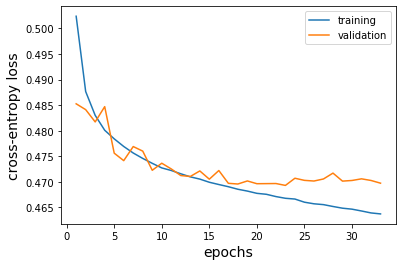

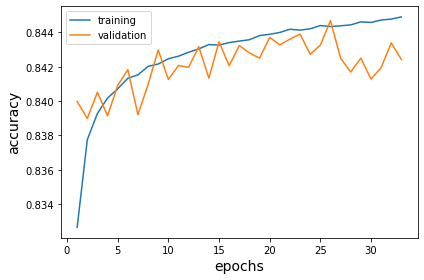

In [7]:
trainingMetrics(dips.modelName,dips.modelDir)

Ok - the training looks *reasonable* - and I evaluated the performance in another nb... and it also looks good!

In [8]:
dips.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40, 13)       0                                            
__________________________________________________________________________________________________
masking_1 (Masking)             (None, 40, 13)       0           input_1[0][0]                    
__________________________________________________________________________________________________
Phi0_Dense (TimeDistributed)    (None, 40, 100)      1400        masking_1[0][0]                  
__________________________________________________________________________________________________
Phi0_BatchNormalization (TimeDi (None, 40, 100)      400         Phi0_Dense[0][0]                 
__________________________________________________________________________________________________
Phi0_ReLU 

I want to save the figures to a subdirectory dictated by the model, so make a new directory if one doesn't exist yet!

In [5]:
figDir = 'figures/' + dips.modelDir.split('/')[-1]

if not os.path.exists(figDir):
    os.mkdir(figDir)
    
figDir += ('/' + dips.modelName)
if not os.path.exists(figDir):
    os.mkdir(figDir)
    
if not os.path.exists(f'{figDir}/jetDisplays'):
    os.mkdir(f'{figDir}/jetDisplays')

### 1. Jet Displays <a id='jetDisplays'></a>


In [6]:
pdg_to_class = {0:0, 4:1, 5:2, 15:3}
pdg_to_flav  = {0:'l', 4:'c', 5:'b', 15:r'$\tau$'}

orig_to_color = {0:'C2',1:'C2',2:'C4',-1:'C0',3:'C3'}

**Load in the attention weights** 
- Load in the track features 
- Load in the scaling model
- Evaluate the model

In [7]:
scalingFile = dataDir+subDir+"/scale_"+dataTagTrain+f'.json'

with open(scalingFile, 'r') as varfile:
    scale = json.load(varfile)

In [92]:
scale

{'ptfrac': {'mean': -3.040702926059751, 'sd': 1.0297803305901383},
 'dr': {'mean': -2.21277464812842, 'sd': 0.9001008879846244},
 'nPixHits': {'mean': 4.029506510339835, 'sd': 1.0178227019504713},
 'nSCTHits': {'mean': 8.044879791420446, 'sd': 1.5737105331368362}}

In [8]:
trkVars = vStr.split("_")

trkVars.pop(-6)
trkVars.pop(-3)

trkVars

['sd0',
 'sz0',
 'nNextToInnHits',
 'nInnHits',
 'nsharedBLHits',
 'nsplitBLHits',
 'nsharedPixHits',
 'nsplitPixHits',
 'nsharedSCTHits',
 'ptfrac',
 'dr',
 'nPixHits',
 'nSCTHits']

In [9]:
X_mini = trk_xr.loc[:,:,trkVars].values

trkMask = np.any(X_mini!=0,axis=-1)
X_mini[:,:,-4:-2][trkMask] = np.log(X_mini[:,:,-4:-2][trkMask])

for i, v in zip(np.arange(-4,0), trkVars[-4:]):
    
    mu, sigma = scale[v]['mean'], scale[v]['sd']
    
    X_mini[:,:,i][trkMask] = (X_mini[:,:,i][trkMask] - mu) / sigma


Define a model for just showing the attention weights.

In [10]:
trk_inputs = Input(shape=(new_nTrks,nFeatures))
masked_inputs = Masking(mask_value=0)(trk_inputs)
tdd = masked_inputs

tws = TimeDistributed(Dense(ppm_sizes[0],activation='tanh'),   name="Alpha1_Dense")(masked_inputs)
u = TimeDistributed(Dense(1,activation='linear'),name="Alpha2_Dense")(tws)

# # Normalize the attention weights
num = Lambda(K.exp, output_shape=compute_output_shape)(u)
# Mask the values
num = Lambda(lambda x: x[0] * getMask(x[1]), output_shape=compute_output_shape)([num,tdd])

den = Sum(axis=1,keepdims=True)(num)
den = Lambda(K.pow, output_shape=compute_output_shape, arguments={'a':-1.})(den)

alpha = Multiply(name="Attention_Softmax")([num,den])

attnBranch = Model(inputs=trk_inputs, outputs=alpha)

In [ ]:
attnBranch.summary()

As expected - there are only two layers with trainable parameters in this model

In [11]:
for layer in ['Alpha1_Dense','Alpha2_Dense']:
    attnBranch.get_layer(layer).set_weights(dips.model.get_layer(layer).get_weights())

In [12]:
w = attnBranch.predict(X_mini).squeeze()

In [13]:
def jetDisplay(jet_df, trk_xr, ijet, attnWeight=None, figDir=''):
    '''
    Draw an jet display for a single je.
    
    Inputs:
    - jet_df: A df holding the (...) for the jet
    - output_trk_array: A dictionary of lists of lists, where the keys of the dictionary 
                        correspond to the track variables, the first list indexes the jet
                        and the nested list indexes the trk
    - ijet: The desired jet to plot
    
    - figures: A relative path to the figure directory
    - subDir: If non-empty, the subDir to save the figures to
    
    '''
    
    pdg = jet_df.loc[ijet,'LabDr_HadF']
    
    jpt = jet_df.loc[ijet,'pt_orig']
    jeta = jet_df.loc[ijet,'eta_orig']
    jphi = jet_df.loc[ijet,'phi_orig']
    
    nTrk = int(jet_df.loc[ijet,'nTrk'])
    
    plt.figure(figsize=(5,5))
    plt.xlabel('$\Delta \eta$',fontsize=16)
    plt.ylabel('$\Delta \phi$',fontsize=16)
    plt.title('{}-jet: $p_T$ = {:3.1f} GeV, $\eta$ = {:1.2f}'.format(pdg_to_flav[pdg],jpt,jeta))
    
    # Draw the jet
    # Since I'm just drawing a single jet, I don't need to know the absolute eta,phi coordinates
    etaCoord, phiCoord = drawCircle(0, 0)
    circleColor = "C{}".format(pdg_to_class[pdg])
    plt.plot(etaCoord, phiCoord, circleColor)
    
    # Plot the tracks, which are already centered from my preprocessing
    # Note - xarray includes the end point for the list - unlike np arrays 
    tetas = trk_xr.loc[ijet,:(nTrk-1),'eta'].values - jeta
    tphis = trk_xr.loc[ijet,:(nTrk-1),'phi'].values - jphi
    tphis[tphis > np.pi] = tphis[tphis > np.pi] - 2*np.pi
    tphis[tphis < -np.pi] = tphis[tphis < -np.pi] + 2*np.pi
    
    torigs = trk_xr.loc[ijet,:(nTrk-1),'orig'].values
    
    w = attnWeight[ijet,:nTrk]
    
    assert len(tetas) == nTrk
    
    cs = [ orig_to_color[o] for o in torigs ]
    plt.scatter(tetas, tphis, nTrk*20*w, color=cs, marker='o')
    
    for c, lab in zip(['C2','C4','C3','C0'],['HF','fragmentation','GEANT','PU']):
        if c == 'C2' and pdg == 0:
            continue
        plt.scatter([],[],color=c,label=lab)
    plt.legend(fontsize=12,bbox_to_anchor=(1,1.02)) 
    
    if len(figDir) > 0:
        plt.savefig(f'{figDir}/jetDisplays/{pdg_to_flav[pdg]}-jet{ijet}.pdf', bbox_inches='tight')
    
    plt.show()

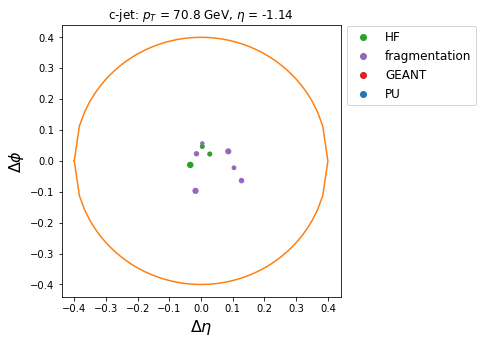

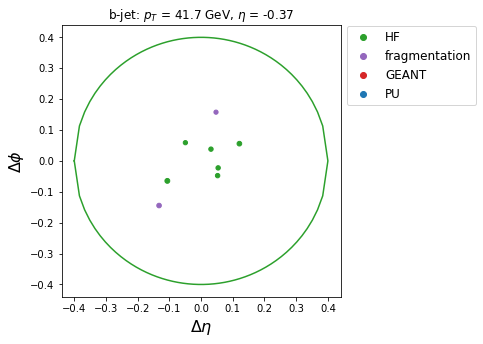

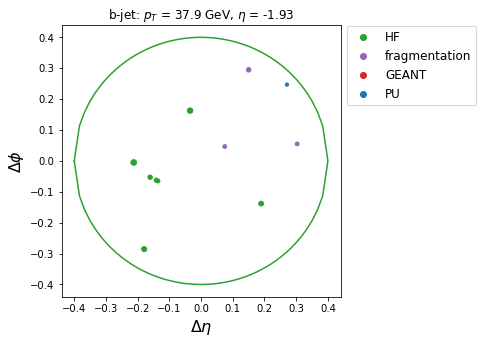

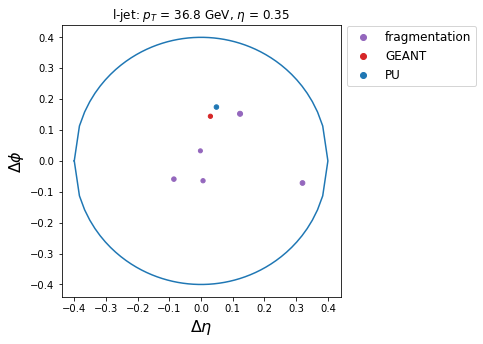

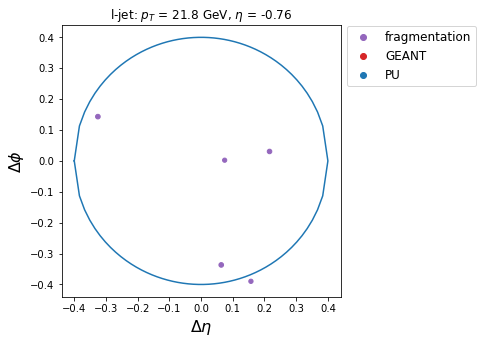

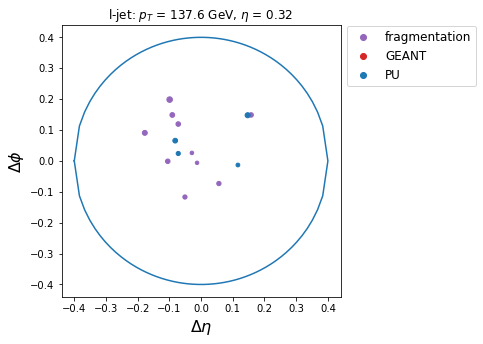

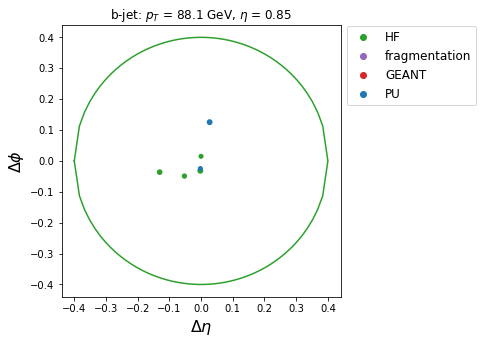

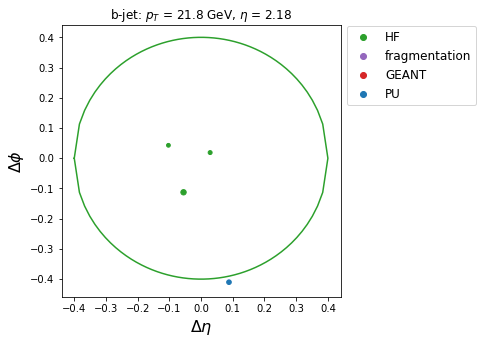

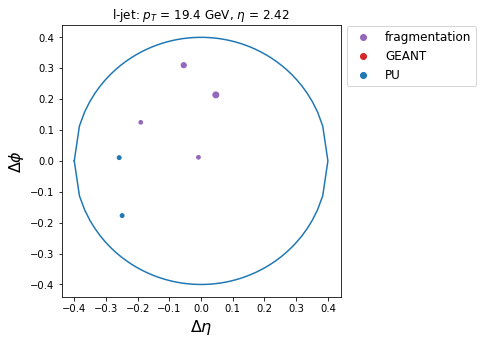

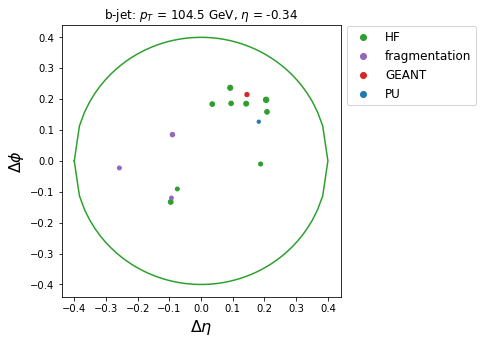

In [473]:
for i in range(10):
    jetDisplay(jet_df, trk_xr, i, attnWeight=w, figDir=figDir)

I can make more plots when I have a final model - but for now, this should be sufficient! 

Ok - now plot w/ attention weights!

### 2. Attention weights with respect to track composition <a id='trkLabels'></a>

Ok, I think just wanted to plot the  mean and standard deviation, *I might want to do some scaling by number of tracks though*???

In [14]:
trk_labels = ['HF','fragmentation','GEANT','PU']

In [15]:
w_nTrk = w * jet_df.nTrk.values.reshape(-1,1)

In [16]:
title='JF trk $p_T$ + IP cuts'

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"$\sqrt{s}$ = 13 TeV, mc16d $t\bar{t}$"

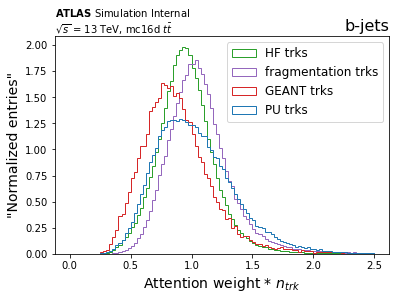

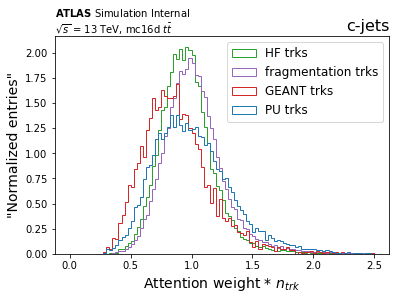

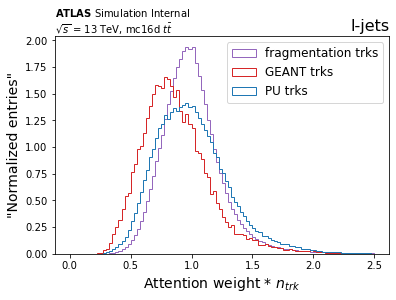

In [477]:
for pdg in [5,4,0]:
    
    plt.figure()
    for oi, l, c in zip([(0,1), 2, 3, -1],trk_labels,['C2','C4','C3','C0']):
    
        mask = trkMask & (jet_df.LabDr_HadF == pdg).values.reshape(-1,1)
        
        if type(oi) == tuple:
            if pdg==0:
                continue
            mask = mask & ((origs==0)|(origs==1))
            
        else:
            mask = mask & (origs==oi)
    
        plt.hist(w_nTrk[mask],100,(0,2.5),color=c,label=f'{l} trks',
                 histtype='step',density=True)


    plt.xlabel('Attention weight * $n_{trk}$',fontsize=14)
    plt.ylabel('"Normalized entries"',fontsize=14)
    plt.legend(loc='upper right',fontsize=12)#bbox_to_anchor=(1,1.02),fontsize=12)

    ax = plt.gca()
    plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)
    plt.title(f'{pdg_to_flav[pdg]}-jets',loc='right',fontsize=16)

    plt.savefig(f'{figDir}/w_nTrk_{pdg_to_flav[pdg]}jets.pdf',bbox_inches='tight')
    plt.show()

In [17]:
for pdg in [5,4,0]:
    
    plt.figure()
    for oi, l, c in zip([(0,1), 2, 3, -1],trk_labels,['C2','C4','C3','C0']):
    
        mask = trkMask & (jet_df.LabDr_HadF == pdg).values.reshape(-1,1)
        
        if type(oi) == tuple:
            if pdg==0:
                continue
            mask = mask & ((origs==0)|(origs==1))
            
        else:
            mask = mask & (origs==oi)
    
        plt.hist(w[mask],100,(0,2.5),color=c,label=f'{l} trks',
                 histtype='step',density=True)


    plt.xlabel('Attention weight * $n_{trk}$',fontsize=14)
    plt.ylabel('"Normalized entries"',fontsize=14)
    plt.legend(loc='upper right',fontsize=12)#bbox_to_anchor=(1,1.02),fontsize=12)

    ax = plt.gca()
    plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)
    plt.title(f'{pdg_to_flav[pdg]}-jets',loc='right',fontsize=16)

    plt.savefig(f'{figDir}/w_nTrk_{pdg_to_flav[pdg]}jets.pdf',bbox_inches='tight')
    plt.show()

NameError: name 'origs' is not defined

<Figure size 432x288 with 0 Axes>

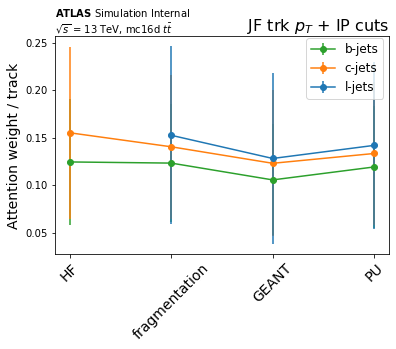

In [178]:
trk_labels = ['HF','fragmentation','GEANT','PU']

for pdg, c, in zip([5,4,0],['C2','C1','C0']):
    
    xi = np.arange(len(trk_labels)) if pdg != 0 else np.arange(1,len(trk_labels))
    
    avg = []
    err = []
    
    for oi in [(0,1), 2, 3, -1]:
    
        mask = trkMask & (jet_df.LabDr_HadF == pdg).values.reshape(-1,1)
        
        if type(oi) == tuple:
            if pdg==0:
                continue
                
            mask = mask & ((origs==0)|(origs==1))
            
        else:
            mask = mask & (origs==oi)
    
    
        avg.append(np.mean(w[mask]))
        err.append(np.std(w[mask]))
    
    plt.errorbar(xi, avg, err, marker='o', color=c, label=f'{pdg_to_flav[pdg]}-jets')
    
plt.xticks(np.arange(len(trk_labels)), trk_labels,rotation=45,fontsize=14)
plt.ylabel('Attention weight / track',fontsize=14)
plt.legend(bbox_to_anchor=(1,1.02),fontsize=12)

ax = plt.gca()
plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)
plt.title(title,loc='right',fontsize=16)

plt.show()

Ok, atm this is quite *uninformative* - but maybe if I multiplied the attention weights by the # of tracks in the jet, then each track would most likely have a value between 0 and 1 ( I think - although I could test this by comparing this for a couple different track multiplicities.)

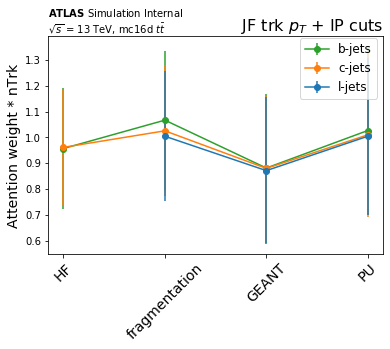

In [478]:
for pdg, c, in zip([5,4,0],['C2','C1','C0']):
    
    xi = np.arange(len(trk_labels)) if pdg != 0 else np.arange(1,len(trk_labels))
    
    avg = []
    err = []
    
    for oi in [(0,1), 2, 3, -1]:

        mask = trkMask & (jet_df.LabDr_HadF == pdg).values.reshape(-1,1)
        
        if type(oi) == tuple:
            if pdg==0:
                continue
                
            mask = mask & ((origs==0)|(origs==1))
            
        else:
            mask = mask & (origs==oi)
    
    
        avg.append(np.mean(w_nTrk[mask]))
        err.append(np.std( w_nTrk[mask]))
    
    plt.errorbar(xi, avg, err, marker='o', color=c, label=f'{pdg_to_flav[pdg]}-jets')
    
plt.xticks(np.arange(len(trk_labels)), trk_labels,rotation=45,fontsize=14)
plt.ylabel('Attention weight * nTrk',fontsize=14)
plt.legend(bbox_to_anchor=(1,1.02),fontsize=12)

ax = plt.gca()
plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)
plt.title(title,loc='right',fontsize=16)

plt.savefig(f'{figDir}/w_nTrk_mu_sigma_trkOrig.pdf',bbox_inches='tight')

plt.show()

Ok - this is even more confusing ;-(

It seems like fragmentation tracks ae even more important for b-jets... woah!

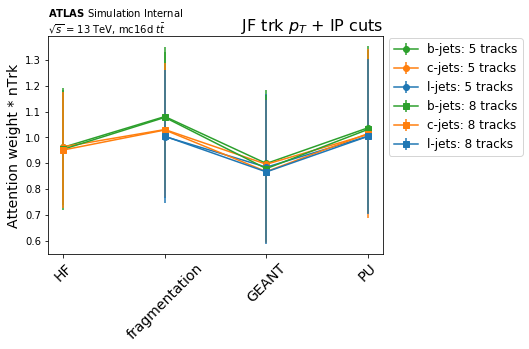

In [180]:
trk_labels = ['HF','fragmentation','GEANT','PU']

for ni,marker in zip([5,8],['o','s']):
    
    for pdg, c, in zip([5,4,0],['C2','C1','C0']):

        xi = np.arange(len(trk_labels)) if pdg != 0 else np.arange(1,len(trk_labels))

        avg = []
        err = []

        for oi in [(0,1), 2, 3, -1]:

            mask = trkMask & (jet_df.LabDr_HadF == pdg).values.reshape(-1,1) 
            mask = mask & (jet_df.nTrk == ni).values.reshape(-1,1)

            if type(oi) == tuple:
                if pdg==0:
                    continue

                mask = mask & ((origs==0)|(origs==1))

            else:
                mask = mask & (origs==oi)


            avg.append(np.mean(w_nTrk[mask]))
            err.append(np.std( w_nTrk[mask]))

        plt.errorbar(xi, avg, err, marker=marker, color=c, label=f'{pdg_to_flav[pdg]}-jets: {ni} tracks')
    
plt.xticks(np.arange(len(trk_labels)), trk_labels,rotation=45,fontsize=14)
plt.ylabel('Attention weight * nTrk',fontsize=14)
plt.legend(bbox_to_anchor=(1,1.02),fontsize=12)

ax = plt.gca()
plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)
plt.title(title,loc='right',fontsize=16)

plt.show()

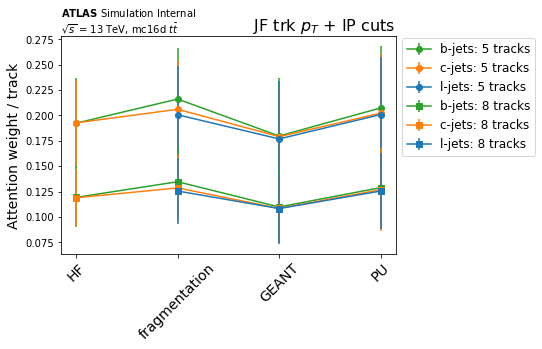

In [176]:
trk_labels = ['HF','fragmentation','GEANT','PU']

for ni,marker in zip([5,8],['o','s']):
    
    for pdg, c, in zip([5,4,0],['C2','C1','C0']):

        xi = np.arange(len(trk_labels)) if pdg != 0 else np.arange(1,len(trk_labels))

        avg = []
        err = []

        for oi in [(0,1), 2, 3, -1]:

            mask = trkMask & (jet_df.LabDr_HadF == pdg).values.reshape(-1,1) 
            mask = mask & (jet_df.nTrk == ni).values.reshape(-1,1)

            if type(oi) == tuple:
                if pdg==0:
                    continue

                mask = mask & ((origs==0)|(origs==1))

            else:
                mask = mask & (origs==oi)


            avg.append(np.mean(w[mask]))
            err.append(np.std( w[mask]))

        plt.errorbar(xi, avg, err, marker=marker, color=c, label=f'{pdg_to_flav[pdg]}-jets: {ni} tracks')
    
plt.xticks(np.arange(len(trk_labels)), trk_labels,rotation=45,fontsize=14)
plt.ylabel('Attention weight / track',fontsize=14)
plt.legend(bbox_to_anchor=(1,1.02),fontsize=12)

ax = plt.gca()
plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)
plt.title(title,loc='right',fontsize=16)

plt.show()

Ok - these are again not hella informative, I could still make these histograms though!!

### 3. Attention weights and track features covariance <a id='trkLabels'></a>

Should I use the scaled or unscaled features?


In [181]:
from scipy.stats import pearsonr

In [183]:
trkMask = np.any(X_mini!=0,axis=-1)

In [458]:
locs = [(i,j) for i in range(3) for j in range(5)]
myRanges = [(-2,2)]*2 + [(-0.5,2.5)] * 7 + [(-3,3)]*4 + [(-1,1),(-1.5,1.5)]

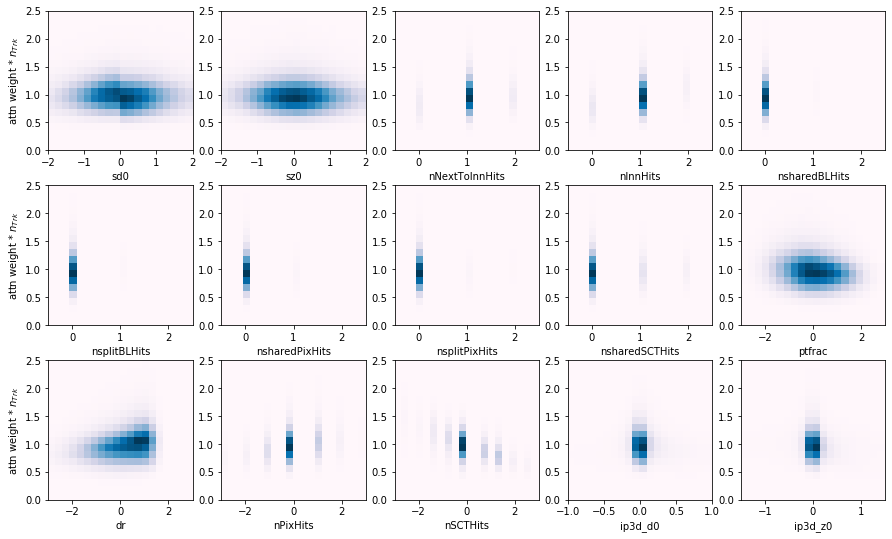

In [479]:
fig, axes = plt.subplots(3,5,figsize=(15,9))

for vi, v, r, (i,j) in zip(range(15),trkVars+['ip3d_d0','ip3d_z0'],myRanges,locs):

    #print(v,r)
    if 'ip3d' in v:
        x = trk_xr.loc[:,:,v].values[trkMask]
    else:
        x = X_mini[:,:,vi][trkMask]

    axes[i,j].hist2d(x,w_nTrk[trkMask],20,[r,(0,2.5)],cmap='PuBu')
    axes[i,j].set_xlabel(v,)
    if j==0:
        axes[i,j].set_ylabel('attn weight * $n_{Trk}$')
    
fig.subplots_adjust(hspace=.25)

plt.savefig(f'{figDir}/inputs_vs_w_nTrk.pdf',bbox_inches='tight')

In [192]:
rs = []

for xi in range(nFeatures):
    
    R = pearsonr(w_nTrk[trkMask], X_mini[:,:,xi][trkMask])
    rs.append(R[0])

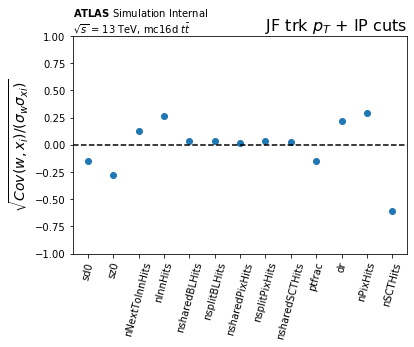

In [480]:
plt.plot(rs,marker='o',linewidth=0)
plt.xticks(np.arange(len(trkVars)),trkVars,rotation=75)

plt.ylabel('$\sqrt{Cov(w, x_i) / (\sigma_w \sigma_{xi})}$',fontsize=14)
plt.ylim(-1,1)

xlim = plt.xlim()
plt.plot(xlim,[0]*2,'k--')
plt.xlim(xlim)

ax = plt.gca()
plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)
plt.title(title,loc='right',fontsize=16)


plt.savefig(f'{figDir}/inputs_vs_w_nTrk_PearsonCoeff.pdf',bbox_inches='tight')
plt.show()

Ok, I think I really need to just make the correlation plots - these are kind of hard to understand at the moment.

### 4. 2D track feature plots with attention weights <a id='2dFeatures'></a>

Ok, $\alpha$ can't be passed as a list, but I can histogramize the weights (or weights * $n_{trk}$), and then loop over which attention bin we're in?

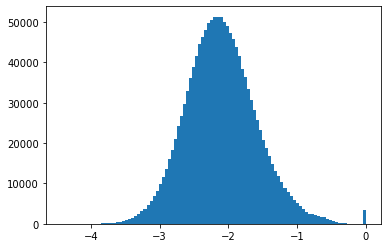

In [213]:
plt.hist(np.log(w[trkMask]),100)
plt.show()

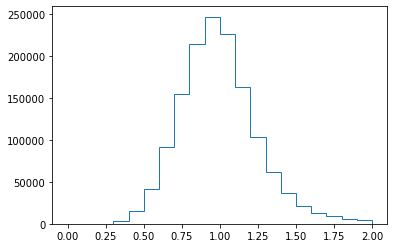

In [337]:
n, edg, _ = plt.hist(w_nTrk[trkMask],20,(0,2),histtype='step')
plt.show()

In [221]:
?np.digitize

In [263]:
ni = np.digitize(w_nTrk[trkMask],edg)

In [233]:
ni.shape

(1421009,)

In [264]:
np.max(ni)

11

In [481]:
def attn2dVars(trk_xr,v1,v2,attnWeight=None,trkMask=None,jetMask=None,
               colors=colors,xlim=(-50,50),ylim=(-50,50),title='',
               nJets=50000,overlay_cuts=False,figDir=''):
    '''
    
    Oh - I should also filter by the type of jet!
    
    '''
    
    mask = trkMask & jetMask
    
    x = trk_xr.loc[:nJets,:,v1].values[mask[:nJets]]
    y = trk_xr.loc[:nJets,:,v2].values[mask[:nJets]]
    
    
    '''
    For the hits plots, it's nice to add some noise to still see trends
    '''
    N = x.shape[0]
    print(title,N,"trks")
    eps = 0.2
    
    if len(np.unique(x)) < 5:
        x += eps * np.random.randn(N)
    if len(np.unique(y)) < 5:
        y += eps * np.random.randn(N)
    
    
    n, edg = np.histogram(w_nTrk[trkMask], len(colors)-2, (0.3,2))
    ni = np.digitize(attnWeight[:nJets][mask[:nJets]], edg)
    
    plt.figure()
    
    for i,c in zip(range(len(colors)+2),colors):
                
        plt.scatter(x[ni==i], y[ni==i], 1, alpha=0.5, color=c)
    
    for c, alpha1, alpha2 in zip(colors,np.concatenate((np.zeros(1),edg)),np.concatenate((edg,np.array([-1])))):
        
        label = f'{alpha1:1.1f} < '
        label += r'$\alpha * n_{trk}$'
        if alpha2 != -1:
            label += f' < {alpha2:1.1f}'
        plt.scatter([],[], 100, color=c, label=label)
    
    if overlay_cuts == True:
        plt.plot([-1,1],[-1.5]*2,'k--') # bottom
        plt.plot([1]*2,[-1.5,1.5],'k--') # right
        plt.plot([-1,1],[1.5]*2,'k--') # top
        plt.plot([-1]*2,[-1.5,1.5],'k--') # leftt
    
    plt.xlabel(v1,fontsize=14)
    plt.ylabel(v2,fontsize=14)
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    plt.legend(loc='center left',bbox_to_anchor=(1,0.5),fontsize=10)
    
    ax = plt.gca()
    plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)
    plt.title(title,loc='right',fontsize=16)
    
    if len(figDir) > 0:
        plt.savefig(f'{figDir}/{v2}_vs_{v1}_{title}.pdf',bbox_inches='tight')
    
    plt.show()

In [368]:
colors=['navy','mediumblue','blue','dodgerblue',
        'deepskyblue','darkturquoise','aqua','aquamarine',
        'springgreen','mediumspringgreen','lime',
        'greenyellow','yellow','gold',
        'orange','darkorange','orangered','red','darkred']

len(colors)

19

**$s_{d0}$ and $s_{z0}$**

b-jets 136530 trks


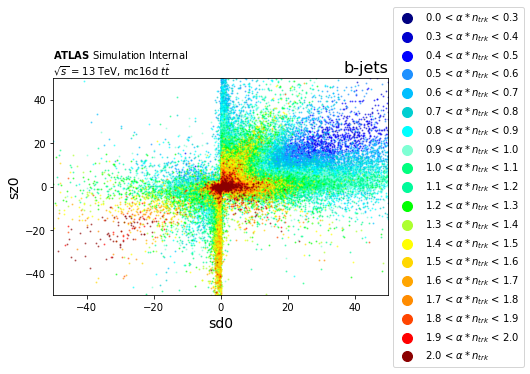

c-jets 27489 trks


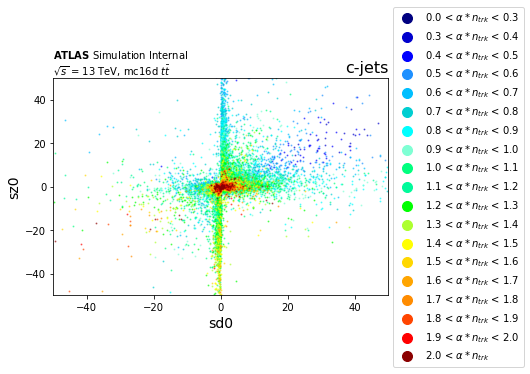

l-jets 181212 trks


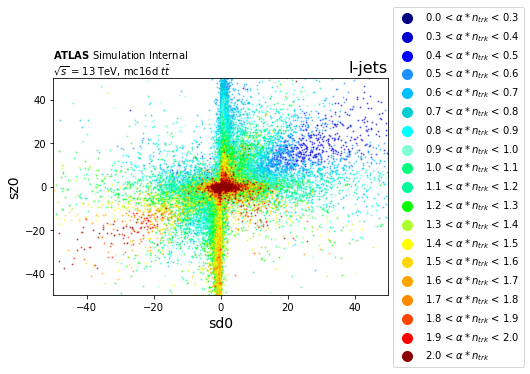

In [482]:
for pdg in [5,4,0]:
    attn2dVars(trk_xr,'sd0','sz0',w_nTrk,trkMask,
               jetMask=(jet_df.LabDr_HadF == pdg).values.reshape(-1,1),
               colors=colors,title=f'{pdg_to_flav[pdg]}-jets',figDir=figDir)

**IBL and PIX1 hits**

b-jets 27688 trks


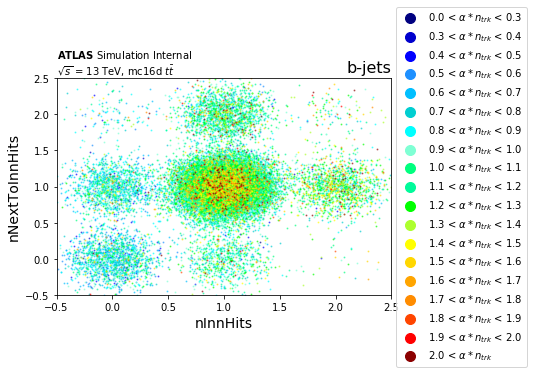

c-jets 5540 trks


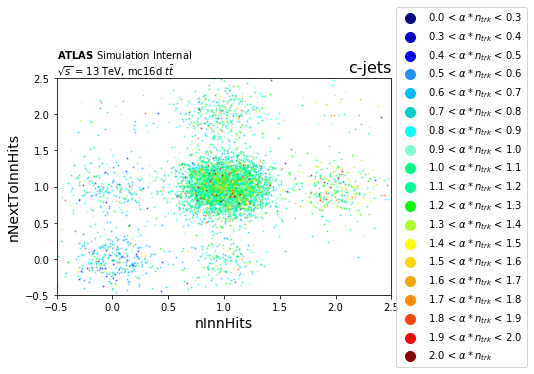

l-jets 35955 trks


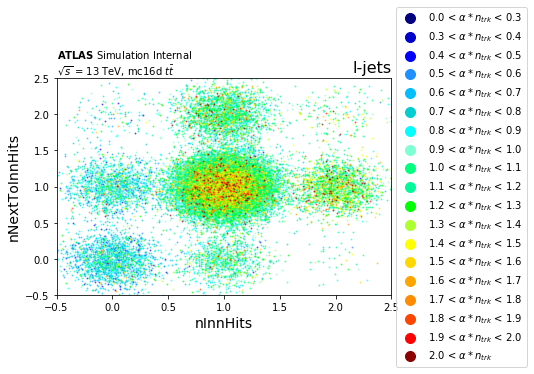

In [483]:
for pdg in [5,4,0]:
    attn2dVars(trk_xr,'nInnHits','nNextToInnHits',w_nTrk,trkMask,
               jetMask=(jet_df.LabDr_HadF == pdg).values.reshape(-1,1),
               colors=colors,xlim=(-0.5,2.5),ylim=(-0.5,2.5),
               title=f'{pdg_to_flav[pdg]}-jets',nJets=10000,figDir=figDir)

**$p_T^{frac}$ and $\Delta R$**

b-jets 136530 trks


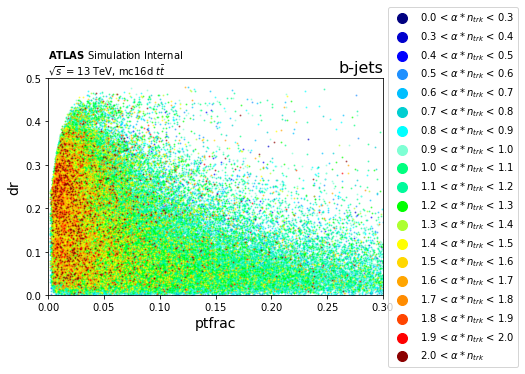

c-jets 27489 trks


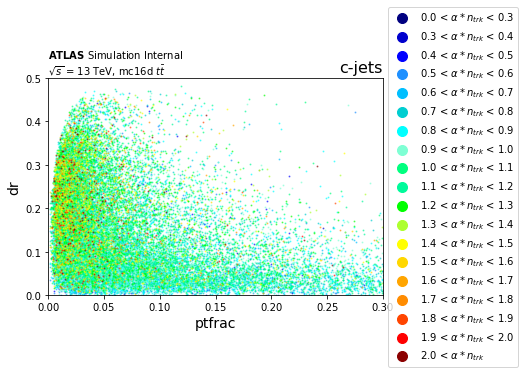

l-jets 181212 trks


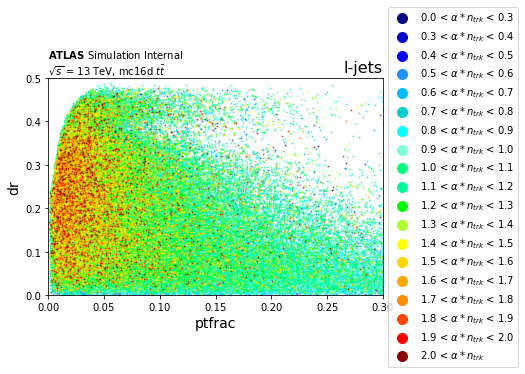

In [484]:
for pdg in [5,4,0]: 
    attn2dVars(trk_xr,'ptfrac','dr',w_nTrk,trkMask,
               jetMask=(jet_df.LabDr_HadF == pdg).values.reshape(-1,1),
               colors=colors,xlim=(0,.3),ylim=(0,.5),
               title=f'{pdg_to_flav[pdg]}-jets',figDir=figDir)

**$d_0$ and $z_0 \sin \theta$**

b-jets 136530 trks


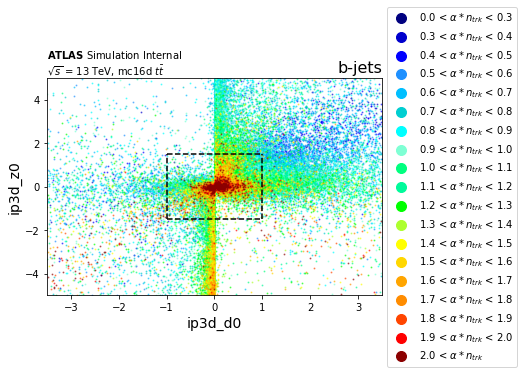

c-jets 27489 trks


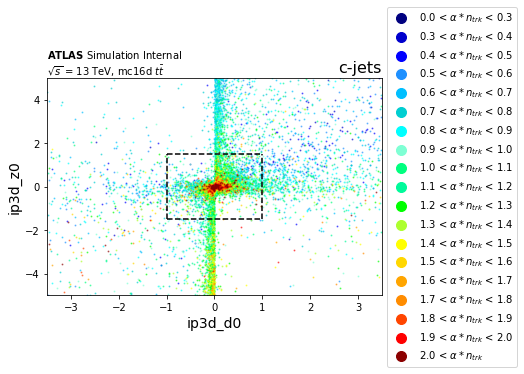

l-jets 181212 trks


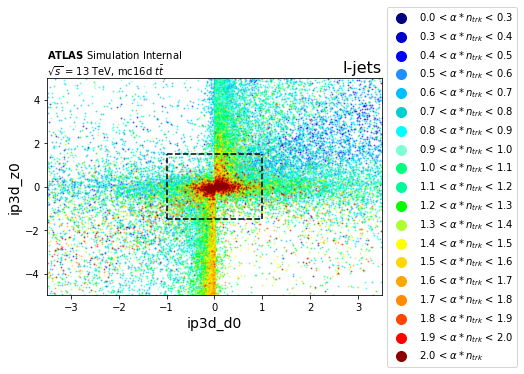

In [485]:
for pdg in [5,4,0]:    
    attn2dVars(trk_xr,'ip3d_d0','ip3d_z0',w_nTrk,trkMask,
               jetMask=(jet_df.LabDr_HadF == pdg).values.reshape(-1,1),
               colors=colors,xlim=(-3.5,3.5),ylim=(-5,5),
               title=f'{pdg_to_flav[pdg]}-jets',overlay_cuts=True,figDir=figDir)